# Limpeza e exploração dos dados

Esse notebook faz parte do projeto final do Bootcamp de Data Science Aplicada da Alura.

Os dados utilizados foram fornecidos pela equipe de Data Intelligence do hospital Sírio-Libanês e disponilizados no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

Ele é dividido em duas parte:
1. [Limpeza](#1--Limpeza-%F0%9F%A7%B9%F0%9F%A7%BC%F0%9F%A7%BA)
2. [Análise Exploratória](#2--An%C3%A1lise-explorat%C3%B3ria-%F0%9F%94%8E)

In [40]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
from funcoes import preenche_tabela, prepare_window, remove_corr_var
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [14]:
# Importando os dados brutos
url = "https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true"
dados = pd.read_excel(url)
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


# 1- Limpeza 🧹🧼🧺

![data](https://tessellationtech.io/wp-content/uploads/2020/03/DataCleansingGIF.gif)

# À primeira vista a base aparenta ter dados de 1925 pacientes diferentes. 

# Porém existem multiplas linhas para cada um dos pacientes, uma para cada valor da janela de tempo (WINDOW).



| Janela      | Descrição                              |
|-------------|----------------------------------------|
| 0-2         | De 0 a 2 horas da admissão             |
| 2-4         | De 2 a 4 horas da admissão             |
| 4-6         | De 4 a 6 horas da admissão             |
| 6-12        | De 6 a 12 horas da admissão            |
| Acima de 12 | Acima de 12 horas a partir da admissão |

In [15]:
dados.shape

(1925, 231)

# O número de pacientes na realidade é de 385!

In [16]:
len(dados["PATIENT_VISIT_IDENTIFIER"].unique())

385

# Agora a checagem de valores faltantes. 

In [17]:
# Por coluna
dados.isna().sum()

PATIENT_VISIT_IDENTIFIER        0
AGE_ABOVE65                     0
AGE_PERCENTIL                   0
GENDER                          0
DISEASE GROUPING 1              5
                             ... 
RESPIRATORY_RATE_DIFF_REL     748
TEMPERATURE_DIFF_REL          694
OXYGEN_SATURATION_DIFF_REL    686
WINDOW                          0
ICU                             0
Length: 231, dtype: int64

In [19]:
# Ao todo
dados.isna().sum().sum()

223863

# Existem muitos valores faltantes na base de dados!

# Como recomendado pela equipe médica do Sírio Libanês, os dados contínuos são preenchidos repetindo o mesmo valor de uma janela seguinte ou anterior.

# Para isso criamos a função preenche_tabela, que recebe como argumento nossa base.

# Além de ter a base preenchida, podemos seguir outra recomendação do Sírio para o desafio: dropar as informações de pacientes que foram levados para UTI na primeira janela de tempo.

# E por fim, dropar as linhas que ainda possuírem informações faltantes.

In [6]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,...,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,...,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,97.750000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,191.500000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,289.250000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.764706,-0.738095,-0.919192,-0.726087,-0.651942,-0.771625,-0.756272,-0.736640,-0.920103,0.000000
max,384.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,0.329660,1.000000,1.000000


# O último passo da preparação dos dados é manter apenas dados da primeira janela.

# Isso é feito pois o modelo só será relevante se puder determinar, assim que o paciente chega  e faz os primeiros exames (primeira janela de tempo), se existe a necessidade ou não de um leito de UTI.

# Para tal iremos inputar ICU = 1 para a primeira janela de pacientes que foram levados a UTI em janelas posteriores, e, em seguida, manter apenas dados da primeira janela de tempo.

In [7]:
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


# Modelos de machine learning podem ter dificuldades quando existe um grande número de colunas altamente correlacionadas!

# Para resolver esse problema, criamos uma função (remove_corr_var) que remove essas colunas de acordo com um ponto de corte. 

# No nosso caso, o ponto de corte escolhido foi 0,95 (para correlações positivas e negativas) !

In [8]:
dados_limpos_corr = remove_corr_var(dados_limpos, 0.95)

# Após todo o tratamento, a base de dados limpa possuí 352 linhas e 100 colunas, em comparação com as 1925 linhas e 231 colunas iniciais.

In [9]:
dados_limpos_corr.shape

(352, 100)

In [21]:
dados_limpos_corr.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.247863,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0-2,0


# 2- Análise exploratória 🔎

![analise](https://www.datadecisionsgroup.com/hubfs/img/eda3.jpg)

# Agora com os dados limpos, podemos explorá-los para extrair alguns insights.
# Nessa parte do notebook iremos observar a relação com a necessidade de UTI apenas com algumas variáveis chave.
# Por se tratarem de 98 features, demandaria muito tempo analisar todas elas.
# As features escolhidas para exploração foram: gênero, idade e saturação média de oxigênio.

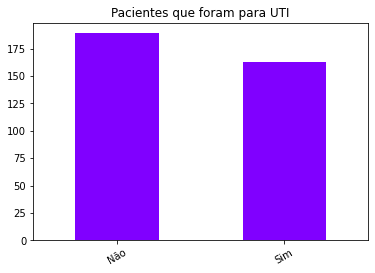

In [122]:
dados_limpos_corr["ICU"].value_counts().plot(kind="bar", colormap="rainbow")
plt.title("Pacientes que foram para UTI")
plt.xticks([0,1], ["Não","Sim"], rotation=30)
plt.show()

# Podemos observar que o número de pacientes que precisaram ir para UTI é bem próximo do número de pacientes que não precisaram.

# Isso é bom sinal, pois modelos de machine learning funcionam melhor com bases de dados balanceadas!

# A seguir podemos explorar as características desses dois diferentes grupos

In [32]:
dados_limpos_corr.groupby("ICU").describe()

PATIENT_VISIT_IDENTIFIER                                                   \
                       count        mean         std  min   25%    50%    75%   
ICU                                                                             
0                      189.0  197.068783  114.991862  3.0  97.0  197.0  299.0   
1                      163.0  187.889571  105.787990  0.0  99.5  183.0  271.0   

           AGE_ABOVE65            ... OXYGEN_SATURATION_DIFF            \
       max       count      mean  ...                    75%       max   
ICU                               ...                                    
0    384.0       189.0  0.322751  ...              -0.979798 -0.858586   
1    382.0       163.0  0.613497  ...              -0.979798 -0.757576   

    HEART_RATE_DIFF_REL                                                    
                  count      mean       std  min  25%  50%  75%       max  
ICU                                                                        
0                 189.0 -0.976191  0.061605 -1.0 -1.0 -1.0 -1.0 -0.535878  
1                 163.0 -0.976686  0.057389 -1.0 -1.0 -1.0 -1.0 -0.652126  

[2 rows x 784 columns]

# Abaixo o gráfico da proporção de paciente que foram para UTI baseado no percentil de idade.

# OBS: Por conta de questões de privacidade dos pacientes a idade foi fornecida em percentis.

# Porém dá pra ter a clara noção que a proporção de internados na UTI cresce com a idade.

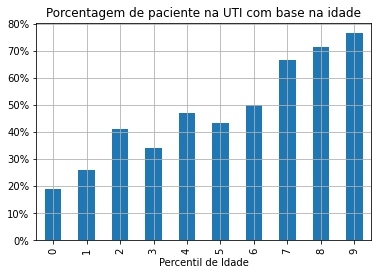

In [123]:
ax = dados_limpos_corr.groupby("AGE_PERCENTIL")["ICU"].mean().plot(kind="bar", grid= True)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))
plt.title("Porcentagem de paciente na UTI com base na idade")
plt.xlabel("Percentil de Idade")
plt.show()

# Abaixo as proporções separados por gênero.

# Podemos observar que as mulheres desenvolveram menos vezes formas mais graves da doença que homens, o que provavelmente é explicado por diversas outras variáveis.

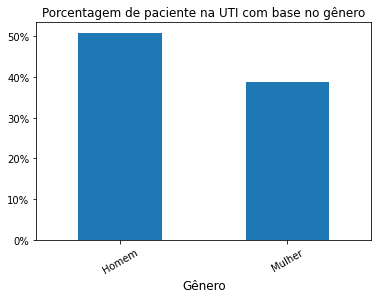

In [84]:
ax = dados_limpos_corr.groupby("GENDER")["ICU"].mean().plot(kind="bar")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.title("Porcentagem de paciente na UTI com base no gênero")
plt.xticks([0,1], ["Homem","Mulher"], rotation=30)
plt.xlabel("Gênero", fontsize="large")
plt.show()

# Uma outra variável que podemos explorar é a Saturação de Oxigênio Média.
# Baixa saturação de oxigênio é um dos principais parâmetros que justifica a ida para UTI de um paciente.
#  Consequentemente o uso de oxímetros pelos infectados pela COVID foi muito comum na pandemia pela possibilidade de monitar em casa a piora do estado clínico.
# Podemos comparar os histogramas dessa variável entre os que foram ou não para UTI.
# O gráfico não é muito esclarecedor, mas podemos ver que todos outliers foram para a UTI.

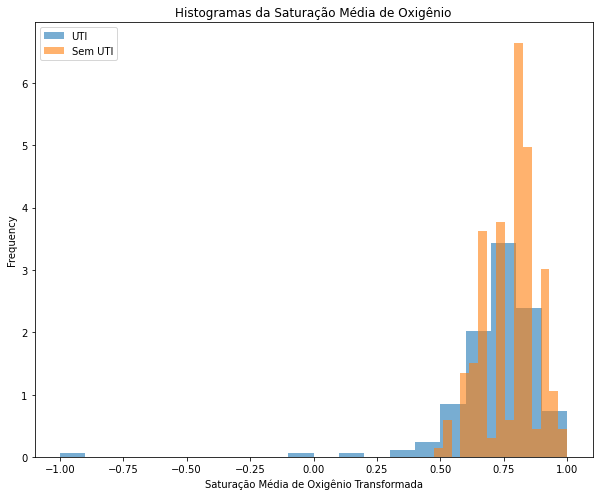

In [126]:
dados_limpos_corr[dados_limpos_corr["ICU"]==1]["OXYGEN_SATURATION_MEAN"].plot(kind="hist",density=True, bins=20, alpha = 0.6,
                                                                             label = "UTI", figsize= (10,8))
dados_limpos_corr[dados_limpos_corr["ICU"]==0]["OXYGEN_SATURATION_MEAN"].plot(kind="hist",density=True, bins=15, alpha = 0.6,
                                                                             label = "Sem UTI")
plt.title("Histogramas da Saturação Média de Oxigênio", fontsize ="large")
plt.xlabel("Saturação Média de Oxigênio Transformada")
plt.legend()
plt.show()

# Assim terminamos nossa análise exploratória. O desenvolvimentos dos modelos de machine learning estão no próximo notebook!

In [20]:
# Para salvar a base limpa em um novo arquivo .csv
#dados_limpos_corr.to_csv("dados_limpos", index=False)